# Synthetic data 1 

## Scenario setup

Synthetic data 1: N_1 = 100, N_2 = 120, N_3 = 180

y_1 ~ HetGaussian

y_2 ~ Poisson

y_3 ~ Categorical K = 3

Input data for each N_d has dimension 2.

Each inputs are uniformly distributed. True n_latent is 3. True A_T in notebook.

Total J = 2 + 1 + 3 = 6

In [1]:
import numpy as np
import torch
import gpytorch
import matplotlib.pyplot as plt
import seaborn as sns
import pyro
import pyro.distributions as dist

import tqdm

import warnings
warnings.filterwarnings('ignore')

In [2]:
class ExactGP(gpytorch.models.ExactGP):
            
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=2)
        )
                
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [3]:
N_1 = 100
N_2 = 120
N_3 = 180
N = 1000
input_dim = 2
n_latents = 3
train_x = None
train_y = None

In [4]:
# initialise the model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGP(train_x=train_x, train_y=train_y, likelihood=likelihood)

In [5]:
model.covar_module.base_kernel.lengthscale

tensor([[0.6931, 0.6931]], grad_fn=<SoftplusBackward0>)

In [6]:
hypers = [
    {
        'likelihood.noise_covar.noise': torch.tensor(1.),
        'covar_module.outputscale': torch.tensor(1.),
        'covar_module.base_kernel.lengthscale': torch.tensor([[.8, .4]]),
    }, 
    {
        'likelihood.noise_covar.noise': torch.tensor(1.),
        'covar_module.outputscale': torch.tensor(1.),
        'covar_module.base_kernel.lengthscale': torch.tensor([[.4, .8]]),
    },
    {
        'likelihood.noise_covar.noise': torch.tensor(1.),
        'covar_module.outputscale': torch.tensor(1.),
        'covar_module.base_kernel.lengthscale': torch.tensor([[.2, .8]]),
    }
]

In [7]:
X = torch.linspace(0, 1, N).repeat(2,1).T
Y = torch.empty((N,n_latents))

# TODO: add non-random missing gaps
train_x1_obs = torch.tensor(np.sort(np.random.choice(np.arange(N), N_1, replace=False)))
train_x2_obs = torch.tensor(np.sort(np.random.choice(np.arange(N), N_2, replace=False)))
train_x3_obs = torch.tensor(np.sort(np.random.choice(np.arange(N), N_3, replace=False)))


train_x1 = X[train_x1_obs]
train_x2 = X[train_x2_obs]
train_x3 = X[train_x3_obs]

In [8]:
train_i_task1 = torch.full((train_x1_obs.shape[0],1), dtype=torch.long, fill_value=0)
train_i_task2 = torch.full((train_x2_obs.shape[0],1), dtype=torch.long, fill_value=1)
train_i_task3 = torch.full((train_x3_obs.shape[0],1), dtype=torch.long, fill_value=2)

In [9]:
full_train_i = torch.cat([train_i_task1, train_i_task2, train_i_task3])
full_train_x = torch.cat([train_x1, train_x2, train_x3])

In [10]:
model.initialize(**hypers[0])

model.eval()

torch.manual_seed(55)
with gpytorch.settings.prior_mode(True):
    Y[:,0] = model(X).sample()

model.initialize(**hypers[1])
torch.manual_seed(88)
with gpytorch.settings.prior_mode(True):
    Y[:,1] = model(X).sample()

model.initialize(**hypers[2])
torch.manual_seed(88)
with gpytorch.settings.prior_mode(True):
    Y[:,2] = model(X).sample()

<AxesSubplot:>

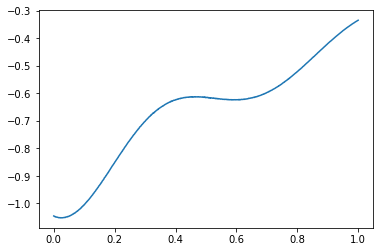

In [11]:
sns.lineplot(X[:,0], Y[:,0])

<AxesSubplot:>

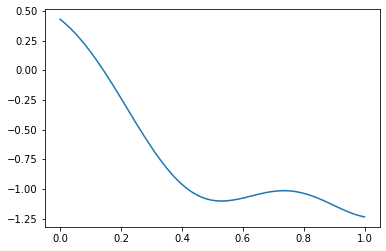

In [12]:
sns.lineplot(X[:,0], Y[:,1])

<AxesSubplot:>

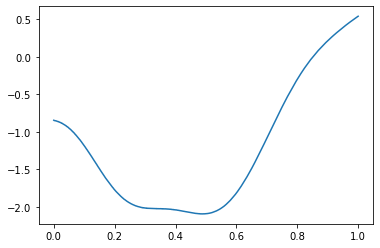

In [13]:
sns.lineplot(X[:,0], Y[:,2])

In [14]:
# g_11 = lambda x: 1 / (1 + np.exp(-x))
# g_21 = lambda x: np.exp(x)
# g_31 = lambda x: x
# g_32 = lambda x: np.exp(x)

In [15]:
A = torch.tensor([
    [1.1, -0.5, .33, 1.1, .55, -0.25], # A_1
    [-.5, 0.2, .33, -.5, -.25, .1], # A_2
    [-.5, -.8, .33, -.5, -.25, -.4], # A_3
]).T
A

tensor([[ 1.1000, -0.5000, -0.5000],
        [-0.5000,  0.2000, -0.8000],
        [ 0.3300,  0.3300,  0.3300],
        [ 1.1000, -0.5000, -0.5000],
        [ 0.5500, -0.2500, -0.2500],
        [-0.2500,  0.1000, -0.4000]])

<AxesSubplot:>

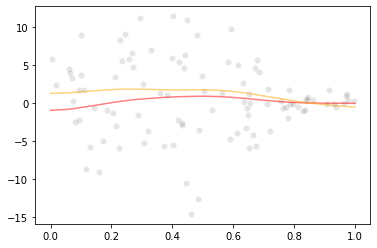

In [16]:
torch.manual_seed(55)

f_11 = Y @ A[0,:]
f_12 = Y @ A[1,:]
y_1 = dist.Normal(f_11[train_x1_obs], f_12[train_x1_obs].exp())()

sns.lineplot(X[:,0], f_11, color='red', alpha=.5)
sns.lineplot(X[:,0], f_12, color='orange', alpha=.5)
sns.scatterplot(X[train_x1_obs,0], y_1, color='black', alpha=.1)

<AxesSubplot:>

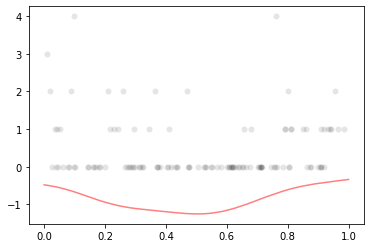

In [17]:
torch.manual_seed(55)

f_21 = Y @ A[2,:]
y_2 = dist.Poisson(f_21[train_x2_obs].exp())()

sns.lineplot(X[:,0], f_21, color='red', alpha=.5)
sns.scatterplot(X[train_x2_obs,0], y_2, color='black', alpha=.1)

<AxesSubplot:>

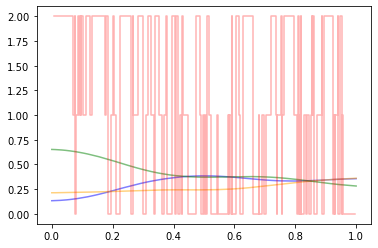

In [18]:
torch.manual_seed(55)

f_31 = Y @ A[3,:]
f_32 = Y @ A[4,:]
f_33 = Y @ A[5,:]
f_3 = torch.stack([f_31, f_32, f_33], dim=-1)
p_3 = f_3.softmax(dim=-1)
# y_2 = torch.normal(f_21, .2)
y_3 = dist.Categorical(p_3[train_x3_obs])()

sns.lineplot(X[:,0], p_3[:,0], color='blue', alpha=.5)
sns.lineplot(X[:,0], p_3[:,1], color='orange', alpha=.5)
sns.lineplot(X[:,0], p_3[:,2], color='green', alpha=.5)
sns.lineplot(X[train_x3_obs,0], y_3, color="red", drawstyle="steps-pre", alpha=.3)

## Example of training model setting num_latents = 1

In [124]:
train_x = full_train_x
train_y = torch.cat([y_1, y_2, y_3], dim=-1)
# train_y = torch.stack([y_1, y_2], dim=-1)
# train_y = y_1
test_x = X

if torch.cuda.is_available():
    train_x, train_y, test_x  = train_x.cuda(), train_y.cuda(), test_x.cuda()

In [138]:
class MultitaskGPModel(gpytorch.models.ApproximateGP):
    def __init__(self, num_tasks, kernel, num_latents=1, name_prefix="lmc_mogp"):
        
        self.name_prefix = name_prefix
        
        # Let's use a different set of inducing points for each latent function
        num_inducing = 50
        inducing_points = torch.linspace(0, 1, num_inducing).expand(num_latents, input_dim, num_inducing).permute(0,2,1)
        
        variational_distribution = gpytorch.variational.MeanFieldVariationalDistribution(
            inducing_points.size(-2), batch_shape=torch.Size([num_latents])
        )

        # We have to wrap the VariationalStrategy in a LMCVariationalStrategy
        # so that the output will be a MultitaskMultivariateNormal rather than a batch output
        base_variational_strategy = gpytorch.variational.VariationalStrategy(
                self, inducing_points, 
                variational_distribution, # variational distribution over the inducing point values, q(u),
                learn_inducing_locations=True
            )
        
        variational_strategy = gpytorch.variational.LMCVariationalStrategy(
            base_variational_strategy=base_variational_strategy,
            num_tasks=num_tasks,
            num_latents=num_latents,
            latent_dim=-1
        )
        
        super().__init__(variational_strategy=variational_strategy)
        
        # The mean and covariance modules should be marked as batch
        # so we learn a different set of hyperparameters
        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([num_latents]))
        self.covar_module = kernel

    def forward(self, x):
        # The forward function should be written as if we were dealing with each output
        # dimension in batch
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        # print("mean_batch_shape:", self.mean_module.batch_shape)
        # print("covar_batch_shape:", self.covar_module.batch_shape)
        print("covar_x_shape:", covar_x.shape)
        print("covar_x_batch_shape:", covar_x.batch_shape)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
    @pyro.poutine.scale(scale=1.0/(3000.0))
    def guide(self, x, y):
         # Get q(f) - variational (guide) distribution of latent function
        function_dist = self.pyro_guide(x)
        # assert function_dist.batch_shape == (1000,)
        
        print("guide event_shape:", function_dist.event_shape) # (4,)
        print("guide batch_shape:", function_dist.batch_shape) # (1000,)

        # Use a plate here to mark conditional independencies
        # with pyro.plate(self.name_prefix + ".data_plate", dim=-1):
        with pyro.plate(self.name_prefix + ".data_plate", dim=-1):
            # Sample from latent function distribution
            f = pyro.sample(self.name_prefix + ".f(x)", function_dist)
        
        
    @pyro.poutine.scale(scale=1.0/(3000.0))
    def model(self, x, y):
        pyro.module(self.name_prefix + ".gp", self)

        # Get p(f) - prior distribution of latent function
        function_dist = self.pyro_model(x)
        
        print("model event_shape:", function_dist.event_shape) # (4,)
        print("model batch_shape:", function_dist.batch_shape) # (1000,)

        # Use a plate here to mark conditional independencies
        # with pyro.plate(self.name_prefix + ".data_plate", dim=-1):
        with pyro.plate(self.name_prefix + ".data_plate", dim=-1):
            # Sample from latent function distribution
            f = pyro.sample(self.name_prefix + ".f(x)", function_dist)
            
            # print(function_samples)
            # Sample from observed distribution
            print("y[0] shape:", y[task_indices.squeeze(-1)==0].shape)
            pyro.sample(
                self.name_prefix + ".y_1",
                dist.Normal(f[task_indices.squeeze(-1)==0,0], f[task_indices.squeeze(-1)==0,1].exp()).to_event(1),
                # obs=y[...,0]
                obs=y[task_indices.squeeze(-1)==0]
            )

            pyro.sample(
                self.name_prefix + ".y_2",
                dist.Poisson(f[task_indices.squeeze(-1)==1,2].exp()).to_event(1),
                # obs=y[...,1],
                obs=y[task_indices.squeeze(-1)==1]
            )
            
            # pyro.sample(
            #     self.name_prefix + ".y_3",
            #     dist.Poisson(f[...,3].exp()).to_event(1),
            #     # obs=y[...,2],
            #     obs=y[task_indices.squeeze(-1)==0]
            # )
            
        # print(dist.Normal(function_samples, torch.tensor(1.)).log_prob(y))
            # print(dist.Normal(function_samples, torch.tensor(1.)).shape())

In [73]:
model = MultitaskGPModel(inducing_points=train_x, num_tasks=4, num_latents=1)
# likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_tasks)

In [82]:
pyro.clear_param_store()

num_iter = 800
num_particles = 5

# optimizer = pyro.optim.Adam({"lr": 0.01})
elbo = pyro.infer.Trace_ELBO(num_particles=num_particles, vectorize_particles=True, retain_graph=True)
# elbo = pyro.infer.Trace_ELBO(vectorize_particles=True, retain_graph=True)

initial_lr = 0.01
gamma = 0.1  # final learning rate will be gamma * initial_lr
lrd = gamma ** (1 / num_iter)
optimizer = pyro.optim.ClippedAdam({'lr': initial_lr, 'lrd': lrd})

svi = pyro.infer.SVI(model.model, model.guide, optimizer, elbo)

model.train()
iterator = tqdm.notebook.tqdm(range(num_iter))
loss_list = []
for i in iterator:
    model.zero_grad()
    loss = svi.step(train_x, train_y)
    loss_list.append(loss)
    iterator.set_postfix(loss=loss)

  0%|          | 0/800 [00:00<?, ?it/s]

/home/cao/miniconda3/envs/pytorch/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

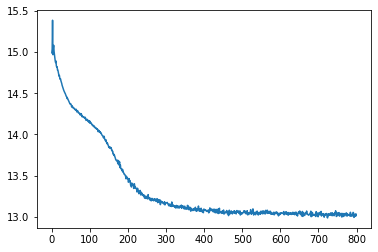

In [83]:
sns.lineplot(np.arange(0, len(loss_list)), loss_list)

In [84]:
def percentiles_from_samples(samples, percentiles=[0.05, 0.5, 0.95]):
    num_samples = samples.size(0)
    samples = samples.sort(dim=0)[0]

    # Get samples corresponding to percentile
    percentile_samples = [samples[int(num_samples * percentile)] for percentile in percentiles]

    # Smooth the samples
    kernel = torch.full((1, 1, 5), fill_value=0.2)
    percentiles_samples = [
        torch.nn.functional.conv1d(percentile_sample.view(1, 1, -1), kernel, padding=2).view(-1)
        for percentile_sample in percentile_samples
    ]

    return percentile_samples

In [85]:
# define test set (optionally on GPU)
denser = 2 # make test set 2 times denser then the training set
test_x = torch.linspace(0, 1, N).float()#.cuda()

model.eval()
with torch.no_grad():
    output = model(test_x)

# Get E[exp(f)] via f_i ~ GP, 1/n \sum_{i=1}^{n} exp(f_i).
# Similarly get the 5th and 95th percentiles
samples = output(torch.Size([1000]))
lower, mean, upper = percentiles_from_samples(samples)

# Draw some simulated y values
mu_sim = model(test_x)()
y_sim = torch.stack(
    [dist.Normal(mu_sim[:,0].detach(), torch.tensor(1.))(),
     dist.Poisson(mu_sim[:,1].detach().exp())(), 
     dist.Normal(mu_sim[:,2].detach(), mu_sim[:,3].detach().exp())()],
    dim=-1
)

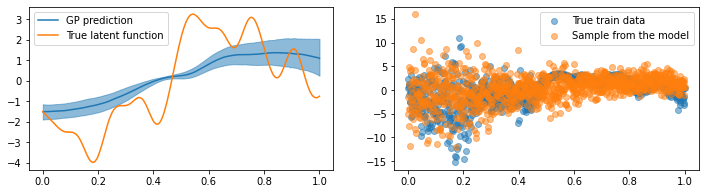

In [128]:
# visualize the result
fig, (func, samp) = plt.subplots(1, 2, figsize=(12, 3))
line, = func.plot(test_x, mean[:,0].detach().cpu().numpy(), label='GP prediction')
func.fill_between(
    test_x, lower[:,0].squeeze().detach().cpu().numpy(),
    upper[:,0].squeeze().detach().cpu().numpy(), color=line.get_color(), alpha=0.5
)

func.plot(test_x, f_11, label='True latent function')
func.legend()

# sample from p(y|D,x) = \int p(y|f) p(f|D,x) df (doubly stochastic)
samp.scatter(train_x, train_y[:,0], alpha = 0.5, label='True train data')
samp.scatter(train_x, y_sim[:,0].cpu().detach().numpy(), alpha=0.5, label='Sample from the model')
samp.legend()

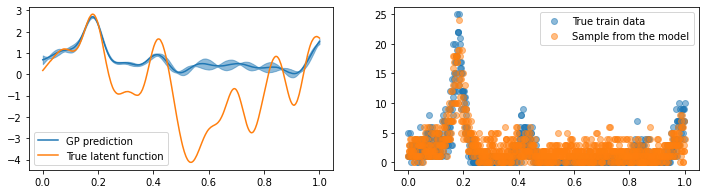

In [87]:
# visualize the result
fig, (func, samp) = plt.subplots(1, 2, figsize=(12, 3))
line, = func.plot(test_x, mean[:,1].detach().cpu().numpy(), label='GP prediction')
func.fill_between(
    test_x, lower[:,1].squeeze().detach().cpu().numpy(),
    upper[:,1].squeeze().detach().cpu().numpy(), color=line.get_color(), alpha=0.5
)

func.plot(test_x, f_21, label='True latent function')
func.legend()

# sample from p(y|D,x) = \int p(y|f) p(f|D,x) df (doubly stochastic)
samp.scatter(train_x, train_y[:,1], alpha = 0.5, label='True train data')
samp.scatter(train_x, y_sim[:,1].cpu().detach().numpy(), alpha=0.5, label='Sample from the model')
samp.legend()

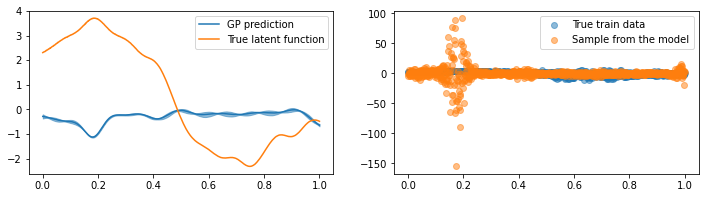

In [88]:
# visualize the result
fig, (func, samp) = plt.subplots(1, 2, figsize=(12, 3))
line, = func.plot(test_x, mean[:,2].detach().cpu().numpy(), label='GP prediction')
func.fill_between(
    test_x, lower[:,2].squeeze().detach().cpu().numpy(),
    upper[:,2].squeeze().detach().cpu().numpy(), color=line.get_color(), alpha=0.5
)

func.plot(test_x, f_31, label='True latent function')
func.legend()

# sample from p(y|D,x) = \int p(y|f) p(f|D,x) df (doubly stochastic)
samp.scatter(train_x, train_y[:,2], alpha = 0.5, label='True train data')
samp.scatter(train_x, y_sim[:,2].cpu().detach().numpy(), alpha=0.5, label='Sample from the model')
samp.legend()

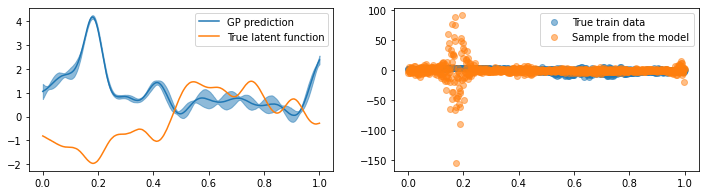

In [89]:
# visualize the result
fig, (func, samp) = plt.subplots(1, 2, figsize=(12, 3))
line, = func.plot(test_x, mean[:,3].detach().cpu().numpy(), label='GP prediction')
func.fill_between(
    test_x, lower[:,3].squeeze().detach().cpu().numpy(),
    upper[:,3].squeeze().detach().cpu().numpy(), color=line.get_color(), alpha=0.5
)

func.plot(test_x, f_32, label='True latent function')
func.legend()

# sample from p(y|D,x) = \int p(y|f) p(f|D,x) df (doubly stochastic)
samp.scatter(train_x, train_y[:,2], alpha = 0.5, label='True train data')
samp.scatter(train_x, y_sim[:,2].cpu().detach().numpy(), alpha=0.5, label='Sample from the model')
samp.legend()

In [90]:
nlpd1 = gpytorch.metrics.negative_log_predictive_density()

Signature:
gpytorch.metrics.negative_log_predictive_density(
    pred_dist: gpytorch.distributions.multivariate_normal.MultivariateNormal,
    test_y: torch.Tensor,
)
Docstring: <no docstring>
File:      ~/miniconda3/envs/pytorch/lib/python3.9/site-packages/gpytorch/metrics/metrics.py
Type:      function


In [28]:
# unit lmc coefficient vector is more interpretable
# we can compare this with the lmc coefficient vector from torch model
A.T / A.T.norm(dim=-1).unsqueeze(-1)

tensor([[ 0.6137, -0.3905, -0.6137,  0.3069],
        [-0.5629,  0.7769,  0.1351, -0.2477]])

In [29]:
# unit lmc coefficient vector is more interpretable
model.variational_strategy.lmc_coefficients.detach() / model.variational_strategy.lmc_coefficients.detach().norm(dim=-1).unsqueeze(-1)

tensor([[0.0672, 0.1774, 0.8224, 0.5363]])

## Example of training model setting num_latents = 2

In [139]:
# from torch.utils.data import TensorDataset, DataLoader
# train_dataset = TensorDataset(train_xc, train_yc)
# train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

# test_dataset = TensorDataset(test_xc, train_yc)
# test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

num_latents = 3

kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(batch_shape=torch.Size([num_latents])), batch_shape=torch.Size([num_latents]))
model = MultitaskGPModel(num_tasks=6, kernel=kernel, num_latents=num_latents)
# likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_tasks)

if torch.cuda.is_available():
    model = model.cuda()

In [140]:
train_x.shape

torch.Size([400, 2])

In [141]:
train_y.shape

torch.Size([400])

In [142]:
f_11[:400][full_train_i.squeeze(-1)==0]

tensor([-0.9432, -0.9412, -0.9410, -0.9396, -0.9380, -0.9370, -0.9371, -0.9352,
        -0.9341, -0.9321, -0.9312, -0.9290, -0.9277, -0.9266, -0.9248, -0.9243,
        -0.9224, -0.9192, -0.9177, -0.9172, -0.9138, -0.9126, -0.9100, -0.9089,
        -0.9071, -0.9030, -0.9005, -0.9006, -0.8974, -0.8940, -0.8916, -0.8889,
        -0.8870, -0.8848, -0.8813, -0.8782, -0.8769, -0.8739, -0.8711, -0.8660,
        -0.8640, -0.8613, -0.8578, -0.8529, -0.8523, -0.8490, -0.8435, -0.8406,
        -0.8389, -0.8351, -0.8303, -0.8267, -0.8230, -0.8209, -0.8169, -0.8121,
        -0.8082, -0.8047, -0.8002, -0.7959, -0.7913, -0.7868, -0.7846, -0.7785,
        -0.7746, -0.7715, -0.7654, -0.7620, -0.7582, -0.7517, -0.7484, -0.7426,
        -0.7386, -0.7333, -0.7290, -0.7252, -0.7192, -0.7156, -0.7093, -0.7046,
        -0.6994, -0.6945, -0.6893, -0.6841, -0.6779, -0.6737, -0.6703, -0.6630,
        -0.6583, -0.6525, -0.6469, -0.6406, -0.6351, -0.6286, -0.6246, -0.6178,
        -0.6124, -0.6083, -0.6000, -0.59

In [143]:
pyro.clear_param_store()

num_iter = 1000
# num_particles = 5

initial_lr = 0.01
gamma = 0.01  # final learning rate will be gamma * initial_lr
lrd = gamma ** (1 / num_iter)

optimizer = pyro.optim.ClippedAdam({
    'lr': initial_lr, 
    'lrd': lrd,
    'betas': (0.95, 0.999)})

# elbo = pyro.infer.Trace_ELBO(num_particles=num_particles, vectorize_particles=True, retain_graph=True)
elbo = pyro.infer.Trace_ELBO(vectorize_particles=True, retain_graph=True)
svi = pyro.infer.SVI(model.model, model.guide, optimizer, elbo)

model.train()
iterator = tqdm.notebook.tqdm(range(num_iter), desc="Epoch")
loss_array = np.zeros(num_iter)
for i in iterator:
    model.zero_grad()
    loss = svi.step(train_x, train_y, task_indices=full_train_i)
    loss_array[i] = loss
    iterator.set_postfix(loss=loss)

# time to compute = 4:46 (CPU)
# time to compute = 1:36 (GPU)

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

covar_x_shape: torch.Size([3, 450, 450])
covar_x_batch_shape: torch.Size([3])
guide event_shape: torch.Size([6])
guide batch_shape: torch.Size([400])
covar_x_shape: torch.Size([3, 400, 400])
covar_x_batch_shape: torch.Size([3])
model event_shape: torch.Size([6])
model batch_shape: torch.Size([400])
y[0] shape: torch.Size([100])
covar_x_shape: torch.Size([3, 450, 450])
covar_x_batch_shape: torch.Size([3])
guide event_shape: torch.Size([6])
guide batch_shape: torch.Size([400])
covar_x_shape: torch.Size([3, 400, 400])
covar_x_batch_shape: torch.Size([3])
model event_shape: torch.Size([6])
model batch_shape: torch.Size([400])
y[0] shape: torch.Size([100])
covar_x_shape: torch.Size([3, 450, 450])
covar_x_batch_shape: torch.Size([3])
guide event_shape: torch.Size([6])
guide batch_shape: torch.Size([400])
covar_x_shape: torch.Size([3, 400, 400])
covar_x_batch_shape: torch.Size([3])
model event_shape: torch.Size([6])
model batch_shape: torch.Size([400])
y[0] shape: torch.Size([100])
covar_x_sh

<AxesSubplot:>

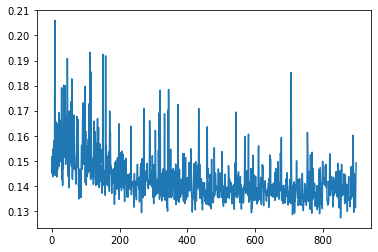

In [144]:
loss_start = 100
sns.lineplot(np.arange(0, len(loss_array) - loss_start), loss_array[loss_start:])

In [145]:
def percentiles_from_samples(samples, percentiles=[0.05, 0.5, 0.95]):
    num_samples = samples.size(0)
    samples = samples.sort(dim=0)[0]

    # Get samples corresponding to percentile
    percentile_samples = [samples[int(num_samples * percentile)] for percentile in percentiles]

    # Smooth the samples
    kernel = torch.full((1, 1, 5), fill_value=0.2)
    percentiles_samples = [
        torch.nn.functional.conv1d(percentile_sample.view(1, 1, -1), kernel, padding=2).view(-1)
        for percentile_sample in percentile_samples
    ]

    return percentile_samples

In [146]:
model.eval()

with torch.no_grad():
    output = model(test_x)

# Similarly get the 5th and 95th percentiles
samples = output(torch.Size([1000]))
mu_sim = model(test_x)()

lower, mean, upper = percentiles_from_samples(samples.cpu())
train_x, train_y, test_x = train_x.cpu(), train_y.cpu(), test_x.cpu()

# Draw some simulated y values
y_sim = torch.stack(
    [dist.Normal(mu_sim[:,0].detach(), mu_sim[:,1].detach().exp())(),
     dist.Poisson(mu_sim[:,2].detach().exp())(), 
     dist.Poisson(mu_sim[:,3].detach().exp())(), 
     dist.Normal(mu_sim[:,4].detach(), mu_sim[:,5].detach().exp())()],
    dim=-1
)

covar_x_shape: torch.Size([3, 1050, 1050])
covar_x_batch_shape: torch.Size([3])
covar_x_shape: torch.Size([3, 1050, 1050])
covar_x_batch_shape: torch.Size([3])


ValueError: too many values to unpack (expected 1)

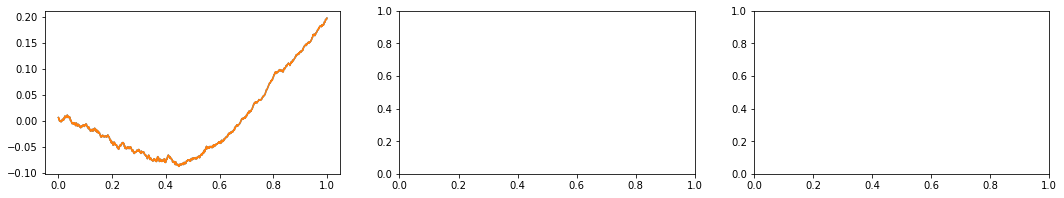

In [147]:
# visualize the result
fig, (*func, samp) = plt.subplots(1, 3, figsize=(18, 3))

for i,j in enumerate(range(2)):
    line, = func[i].plot(test_x, mean[:,j].detach().cpu().numpy(), label='GP prediction')
    func[i].fill_between(
        test_x, lower[:,j].squeeze().detach().cpu().numpy(),
        upper[:,j].squeeze().detach().cpu().numpy(), color=line.get_color(), alpha=0.5
    )
    f_plot = f_11 if i == 0 else f_12
    func[i].plot(test_x, f_plot, label='True latent function')
    func[i].legend()

# sample from p(y|D,x) = \int p(y|f) p(f|D,x) df (doubly stochastic)
samp.scatter(train_x, train_y[:,0], alpha = 0.5, label='True train data')
samp.scatter(train_x, y_sim[:,0].cpu().detach().numpy(), alpha=0.5, label='Sample from the model')
samp.legend()

ValueError: too many values to unpack (expected 1)

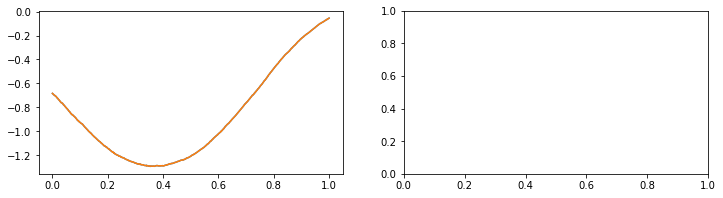

In [148]:
# visualize the result
fig, (func, samp) = plt.subplots(1, 2, figsize=(12, 3))
line, = func.plot(test_x, mean[:,2].detach().cpu().numpy(), label='GP prediction')
func.fill_between(
    test_x, lower[:,2].squeeze().detach().cpu().numpy(),
    upper[:,2].squeeze().detach().cpu().numpy(), color=line.get_color(), alpha=0.5
)

func.plot(test_x, f_21, label='True latent function')
func.legend()

# sample from p(y|D,x) = \int p(y|f) p(f|D,x) df (doubly stochastic)
samp.scatter(train_x, train_y[:,1], alpha = 0.5, label='True train data')
samp.scatter(train_x, y_sim[:,1].cpu().detach().numpy(), alpha=0.5, label='Sample from the model')
samp.legend()

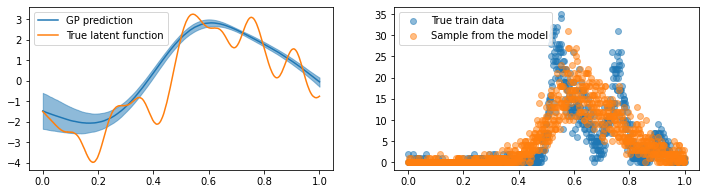

In [30]:
# visualize the result
fig, (func, samp) = plt.subplots(1, 2, figsize=(12, 3))
line, = func.plot(test_x, mean[:,3].detach().cpu().numpy(), label='GP prediction')
func.fill_between(
    test_x, lower[:,3].squeeze().detach().cpu().numpy(),
    upper[:,3].squeeze().detach().cpu().numpy(), color=line.get_color(), alpha=0.5
)

func.plot(test_x, f_31, label='True latent function')
func.legend()

# sample from p(y|D,x) = \int p(y|f) p(f|D,x) df (doubly stochastic)
samp.scatter(train_x, train_y[:,2], alpha = 0.5, label='True train data')
samp.scatter(train_x, y_sim[:,2].cpu().detach().numpy(), alpha=0.5, label='Sample from the model')
samp.legend()

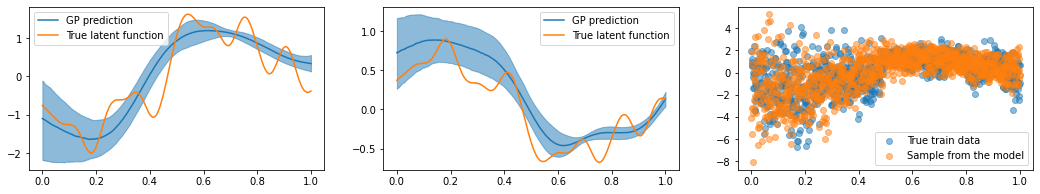

In [31]:
# visualize the result
fig, (*func, samp) = plt.subplots(1, 3, figsize=(18, 3))

for i,j in enumerate(range(4,6)):
    line, = func[i].plot(test_x, mean[:,j].detach().cpu().numpy(), label='GP prediction')
    func[i].fill_between(
        test_x, lower[:,j].squeeze().detach().cpu().numpy(),
        upper[:,j].squeeze().detach().cpu().numpy(), color=line.get_color(), alpha=0.5
    )
    f_plot = f_41 if i == 0 else f_42
    func[i].plot(test_x, f_plot, label='True latent function')
    func[i].legend()

# sample from p(y|D,x) = \int p(y|f) p(f|D,x) df (doubly stochastic)
samp.scatter(train_x, train_y[:,3], alpha = 0.5, label='True train data')
samp.scatter(train_x, y_sim[:,3].cpu().detach().numpy(), alpha=0.5, label='Sample from the model')
samp.legend()

In [117]:
model.variational_strategy.lmc_coefficients

Parameter containing:
tensor([[-0.0718,  0.1248,  0.2181, -0.0140, -0.0235,  0.0588],
        [ 1.2961, -0.5970,  0.4338,  1.2451,  0.6755, -0.3409],
        [-0.6601,  0.0727,  0.9633, -0.6527, -0.2568,  0.0891]],
       device='cuda:0', requires_grad=True)

In [104]:
model.variational_strategy.lmc_coefficients

Parameter containing:
tensor([[-0.0249, -0.0184, -0.4824, -0.0108,  0.0028, -0.0099],
        [-0.9016,  0.8114, -0.2777, -1.5583, -0.9006,  0.4411],
        [ 0.8139,  0.3106, -0.3385,  0.2384, -0.0066,  0.0813]],
       device='cuda:0', requires_grad=True)

In [433]:
lmc1 = np.array(
    [[1.1, -0.7, -1.1, -.75, 1.5], # A_(.,1)
     [-.5, 0.69,  .5,  .64, 1.1]] # A_(.,2)
)
lmc1.T @ lmc1

array([[ 1.46  , -1.115 , -1.46  , -1.145 ,  1.1   ],
       [-1.115 ,  0.9661,  1.115 ,  0.9666, -0.291 ],
       [-1.46  ,  1.115 ,  1.46  ,  1.145 , -1.1   ],
       [-1.145 ,  0.9666,  1.145 ,  0.9721, -0.421 ],
       [ 1.1   , -0.291 , -1.1   , -0.421 ,  3.46  ]])

In [294]:
lmc1.T, lmc1

(array([[ 1.1 , -0.5 ],
        [-0.7 ,  0.69],
        [-1.1 ,  0.5 ],
        [-0.75,  0.64],
        [ 1.5 ,  1.1 ]]),
 array([[ 1.1 , -0.7 , -1.1 , -0.75,  1.5 ],
        [-0.5 ,  0.69,  0.5 ,  0.64,  1.1 ]]))

In [295]:
lmc1_eigenval, lmc1_eigvenvec = np.linalg.eig(lmc1.T @ lmc1)
lmc1_sorted_idx = np.argsort(lmc1_eigenval)[::-1]

In [296]:
lmc1_sorted_idx

array([0, 2, 1, 3, 4])

In [297]:
lmc1_eigenval[lmc1_sorted_idx]

array([ 5.77613079e+00,  2.54206921e+00,  8.28799608e-16, -4.97768112e-19,
       -2.44074976e-16])

In [298]:
lmc1_eigvenvec

array([[-0.48067277,  0.8482957 , -0.2221443 , -0.0546752 ,  0.04419016],
       [ 0.32580523,  0.28219257,  0.37262735, -0.01992809,  0.71981361],
       [ 0.48067277,  0.33053852,  0.2221443 , -0.68725988, -0.67154046],
       [ 0.34375716,  0.28316329,  0.33749004,  0.71475416,  0.05802155],
       [-0.55999048, -0.10641708,  0.80532797, -0.11581813, -0.15994533]])

In [299]:
lmc1_eigvenvec[:,lmc1_sorted_idx]

array([[-0.48067277, -0.2221443 ,  0.8482957 , -0.0546752 ,  0.04419016],
       [ 0.32580523,  0.37262735,  0.28219257, -0.01992809,  0.71981361],
       [ 0.48067277,  0.2221443 ,  0.33053852, -0.68725988, -0.67154046],
       [ 0.34375716,  0.33749004,  0.28316329,  0.71475416,  0.05802155],
       [-0.55999048,  0.80532797, -0.10641708, -0.11581813, -0.15994533]])

In [304]:
lmc1_eigvens = np.around(lmc1_eigenval[lmc1_sorted_idx] * lmc1_eigvenvec[:,lmc1_sorted_idx], decimals=5)
lmc1_2d_eigvens = lmc1_eigvens[:,:2].copy()
lmc1_2d_eigvens.T

array([[-2.77643,  1.88189,  2.77643,  1.98559, -3.23458],
       [-0.56471,  0.94724,  0.56471,  0.85792,  2.0472 ]])

In [305]:
lmc1_2d_eigvenvec = lmc1_eigvenvec[:,lmc1_sorted_idx[:2]].copy()
lmc1_2d_eigvenvec.T

array([[-0.48067277,  0.32580523,  0.48067277,  0.34375716, -0.55999048],
       [-0.2221443 ,  0.37262735,  0.2221443 ,  0.33749004,  0.80532797]])

/home/cao/miniconda3/envs/pytorch/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(-1.0, 1.0)

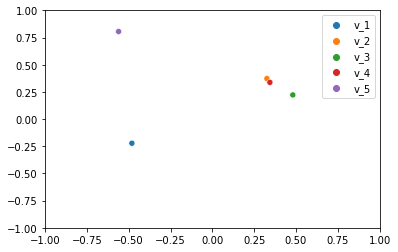

In [303]:
labels = ["v_1", "v_2", "v_3", "v_4", "v_5"]

sns.scatterplot(lmc1_2d_eigvenvec[:,0], lmc1_2d_eigvenvec[:,1], hue=labels)
plt.ylim([-1,1])
plt.xlim([-1,1])

/home/cao/miniconda3/envs/pytorch/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

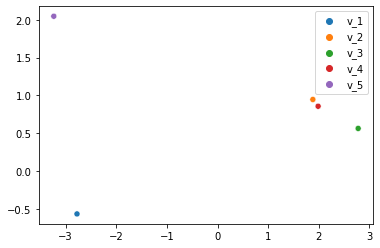

In [306]:
labels = ["v_1", "v_2", "v_3", "v_4", "v_5"]

sns.scatterplot(lmc1_2d_eigvens[:,0], lmc1_2d_eigvens[:,1], hue=labels)

In [345]:
A_mat = model.variational_strategy.lmc_coefficients.detach()
A_mat

tensor([[-1.4765, -0.7216,  2.0492, -0.3095,  1.2799,  0.1736],
        [-0.9383,  0.0209, -0.1986,  0.6307,  1.0694,  0.7383],
        [-1.6807, -0.1871, -0.2878,  0.2863,  0.5180,  0.2221],
        [ 0.5780,  0.0399, -2.1243, -0.6229, -1.6184, -0.2008],
        [ 1.4800, -1.1358, -0.2348,  2.4060,  0.8780, -0.5985],
        [ 0.8209,  0.9534,  0.4158,  0.1189,  0.3474, -0.1370]])

In [346]:
torch.divide(A_mat, torch.norm(A_mat, dim=-1).unsqueeze(-1))

tensor([[-0.5016, -0.2452,  0.6962, -0.1051,  0.4348,  0.0590],
        [-0.5411,  0.0120, -0.1146,  0.3637,  0.6167,  0.4258],
        [-0.9193, -0.1023, -0.1574,  0.1566,  0.2833,  0.1215],
        [ 0.2057,  0.0142, -0.7560, -0.2217, -0.5759, -0.0715],
        [ 0.4577, -0.3513, -0.0726,  0.7442,  0.2716, -0.1851],
        [ 0.5941,  0.6900,  0.3009,  0.0860,  0.2514, -0.0992]])

In [347]:
A_eval, A_evec = np.linalg.eig(A @ A.T)
A_eval, A_evec

(array([ 3.6758194e+00,  1.8948062e-01, -3.4648185e-08,  6.7992314e-20,
         2.4632986e-16, -2.5954159e-33], dtype=float32),
 array([[-6.3002807e-01, -7.0327938e-02,  2.0630810e-01, -2.7396920e-04,
          7.1527416e-01,  1.8025281e-09],
        [ 2.8082007e-01, -2.5708972e-02,  8.4881043e-01,  4.4721356e-01,
         -1.2576894e-01, -1.1023288e-06],
        [-9.1216676e-02,  9.9400467e-01,  6.0284734e-02,  6.1579512e-11,
         -4.0260385e-11, -1.5255655e-16],
        [-6.3002807e-01, -7.0327938e-02,  2.0630810e-01,  2.1917433e-04,
         -5.7221937e-01, -4.4721359e-01],
        [-3.1501403e-01, -3.5163969e-02,  1.0315405e-01,  1.0959067e-04,
         -2.8610969e-01,  8.9442718e-01],
        [ 1.4041004e-01, -1.2854486e-02,  4.2440522e-01, -8.9442712e-01,
          2.5153789e-01,  2.2046577e-06]], dtype=float32))

In [348]:
A_idx_sort = np.argsort(A_eval)[::-1]
# num components
A_eval[A_idx_sort] > 1.

array([ True, False, False, False, False, False])

In [349]:
A.T

tensor([[ 1.1000, -0.5000,  0.3300,  1.1000,  0.5500, -0.2500],
        [-0.5000,  0.2000,  0.3300, -0.5000, -0.2500,  0.1000]])

/home/cao/miniconda3/envs/pytorch/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

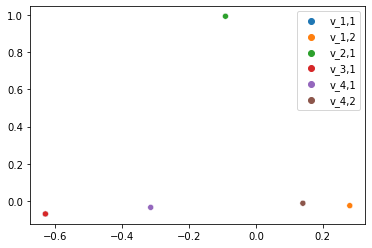

In [350]:
A_comp = A_evec[:,A_idx_sort[:3]].copy()
labels = ["v_1,1", "v_1,2", "v_2,1", "v_3,1", "v_4,1", "v_4,2"]
sns.scatterplot(A_comp[:,0], A_comp[:,1], hue=labels)

### V_mat

In [58]:
# true lmc_coeff = 
# [[1.1, -0.7, -1.1, .55], # A_1
#  [-.5, 0.69, .12, -.22]] # A_2

# get eigven values n vector

V_mat = model.variational_strategy.lmc_coefficients.cpu().detach().T @ model.variational_strategy.lmc_coefficients.cpu().detach()
V_mat

tensor([[ 4.3399, -1.5808,  0.9717,  3.6117,  1.6805, -0.8479],
        [-1.5808,  1.4429,  0.2475, -2.1818, -1.4102,  0.8583],
        [ 0.9717,  0.2475,  3.1100, -0.3588, -0.9303,  0.1441],
        [ 3.6117, -2.1818, -0.3588,  4.3486,  2.1871, -1.4579],
        [ 1.6805, -1.4102, -0.9303,  2.1871,  2.3392, -0.5322],
        [-0.8479,  0.8583,  0.1441, -1.4579, -0.5322,  0.7038]])

In [59]:
V_eval, V_evec = np.linalg.eig(V_mat)
V_eval, V_evec

(array([1.0487436e+01, 3.9358847e+00, 9.4166547e-01, 8.1220055e-01,
        1.0200895e-01, 5.1303115e-03], dtype=float32),
 array([[-0.57588077,  0.37043932,  0.30450982,  0.5225669 ,  0.34839517,
         -0.2096531 ],
        [ 0.3269465 ,  0.10661153,  0.19719575,  0.48519668, -0.69052595,
         -0.36140272],
        [ 0.01467097,  0.8625677 ,  0.02316064, -0.46403104, -0.19690415,
          0.03360397],
        [-0.62918395, -0.06736642, -0.38591787,  0.09540484, -0.5481    ,
          0.37568742],
        [-0.35845828, -0.31644306,  0.6564895 , -0.4774169 , -0.24896295,
         -0.2246855 ],
        [ 0.19206063,  0.052069  ,  0.5366006 ,  0.19787414, -0.0250476 ,
          0.7954117 ]], dtype=float32))

In [60]:
V_idx_sort = np.argsort(V_eval)[::-1]
# num components
V_eval[V_idx_sort] > 1.

array([ True,  True, False, False, False, False])

In [61]:
A.T

tensor([[ 1.1000, -0.5000,  0.3300,  1.1000,  0.5500, -0.2500],
        [-0.5000,  0.2000,  0.3300, -0.5000, -0.2500,  0.1000]])

<AxesSubplot:>

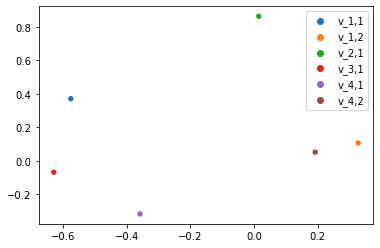

In [62]:
V_comp = V_evec[:,V_idx_sort[:3]].copy()
labels = ["v_1,1", "v_1,2", "v_2,1", "v_3,1", "v_4,1", "v_4,2"]
sns.scatterplot(V_comp[:,0], V_comp[:,1], hue=labels)

In [63]:
V = model.variational_strategy.lmc_coefficients.cpu().detach()
V_dist = np.zeros((5,5))
for i in range(5):
    for j in range(i,5):
        V_dist[i,j] = np.linalg.norm(V[:,i] - V[:,j])
        V_dist[j,i] = V_dist[i,j]
V_dist

array([[0.        , 2.99072528, 2.34659171, 1.21038377, 1.8215338 ],
       [2.99072528, 0.        , 2.01443028, 3.18669772, 2.56952262],
       [2.34659171, 2.01443028, 0.        , 2.85940218, 2.70365119],
       [1.21038377, 3.18669772, 2.85940218, 0.        , 1.52103078],
       [1.8215338 , 2.56952262, 2.70365119, 1.52103078, 0.        ]])

<AxesSubplot:>

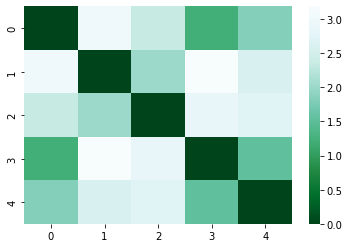

In [64]:
sns.heatmap(V_dist, cmap="BuGn_r", linewidths=0)

### V_mat_norm

In [65]:
V_mat_norm = torch.divide(V_mat, torch.norm(V_mat, dim=-1).unsqueeze(-1))
V_mat_norm

tensor([[ 0.6961, -0.2536,  0.1559,  0.5793,  0.2696, -0.1360],
        [-0.4539,  0.4143,  0.0711, -0.6265, -0.4049,  0.2465],
        [ 0.2842,  0.0724,  0.9095, -0.1049, -0.2721,  0.0421],
        [ 0.5460, -0.3298, -0.0542,  0.6574,  0.3307, -0.2204],
        [ 0.4173, -0.3502, -0.2310,  0.5431,  0.5809, -0.1321],
        [-0.4051,  0.4101,  0.0688, -0.6966, -0.2543,  0.3363]])

In [66]:
V_eval_norm, V_evec_norm = np.linalg.eig(V_mat_norm)
V_eval_norm, V_evec_norm

(array([2.0538509e+00, 1.0526500e+00, 2.7601859e-01, 1.8821944e-01,
        1.5994456e-03, 2.2221666e-02], dtype=float32),
 array([[-0.40267953,  0.26571104,  0.22896154,  0.47563195,  0.21534693,
          0.29004517],
        [ 0.46646342,  0.02982407,  0.19394496,  0.481961  ,  0.35295308,
         -0.75363463],
        [ 0.0937462 ,  0.93830574,  0.01615068, -0.42117128, -0.03639666,
         -0.18285474],
        [-0.4493628 ,  0.02714233, -0.13186806,  0.20029916, -0.38385567,
         -0.43453228],
        [-0.44650203, -0.21747045,  0.5030688 , -0.54190767,  0.2223994 ,
         -0.29613498],
        [ 0.4584558 ,  0.00777157,  0.7995209 ,  0.17412324, -0.7943037 ,
          0.19482945]], dtype=float32))

In [67]:
V_norm_idx_sort = np.argsort(V_eval_norm)[::-1]
# num components
V_eval_norm[V_norm_idx_sort] > 1.

array([ True,  True, False, False, False, False])

In [68]:
A.T

tensor([[ 1.1000, -0.5000,  0.3300,  1.1000,  0.5500, -0.2500],
        [-0.5000,  0.2000,  0.3300, -0.5000, -0.2500,  0.1000]])

In [69]:
np.around(V_evec_norm[:,V_norm_idx_sort[:2]], decimals=4).T

array([[-0.4027,  0.4665,  0.0937, -0.4494, -0.4465,  0.4585],
       [ 0.2657,  0.0298,  0.9383,  0.0271, -0.2175,  0.0078]],
      dtype=float32)

<AxesSubplot:>

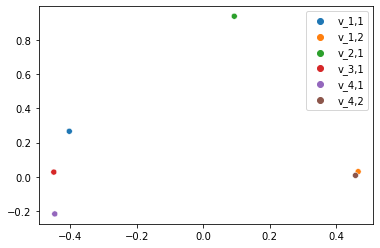

In [70]:
V_comp_norm = V_evec_norm[:,V_norm_idx_sort[:3]].copy()
labels = ["v_1,1", "v_1,2", "v_2,1", "v_3,1", "v_4,1", "v_4,2"]
sns.scatterplot(V_comp_norm[:,0], V_comp_norm[:,1], hue=labels)

In [71]:
V = model.variational_strategy.lmc_coefficients.cpu().detach()
V_norm = torch.divide(V, torch.norm(V, dim=-1).unsqueeze(-1))
V_norm_dist = np.zeros((5,5))
for i in range(5):
    for j in range(i,5):
        V_norm_dist[i,j] = np.linalg.norm(V_norm[:,i] - V_norm[:,j])
        V_norm_dist[j,i] = V_norm_dist[i,j]
V_norm_dist

array([[0.        , 1.53955245, 1.28618217, 0.75673348, 1.47207642],
       [1.53955245, 0.        , 1.3871603 , 1.80594754, 1.65692878],
       [1.28618217, 1.3871603 , 0.        , 1.50767052, 1.74112487],
       [0.75673348, 1.80594754, 1.50767052, 0.        , 1.15536439],
       [1.47207642, 1.65692878, 1.74112487, 1.15536439, 0.        ]])

<AxesSubplot:>

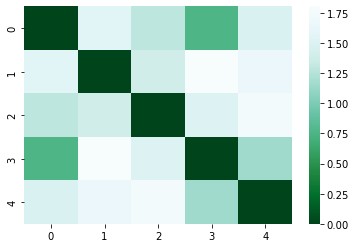

In [72]:
sns.heatmap(V_norm_dist, cmap="BuGn_r", linewidths=0)

<AxesSubplot:>

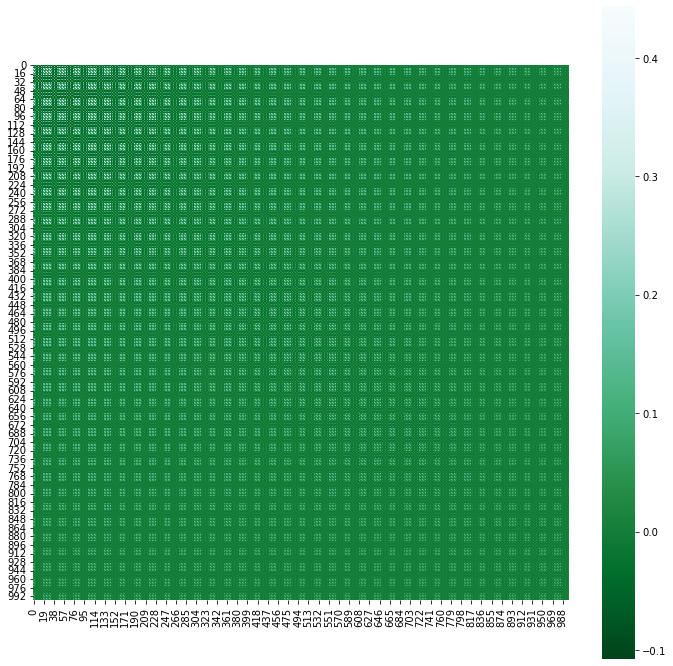

In [531]:
cov_mat = output.covariance_matrix.cpu().detach().numpy()
plt.figure(figsize=(12,12))
sns.heatmap(cov_mat[:1000,:1000], cmap="BuGn_r", square=True)

In [532]:
def cov_to_corr(covariance):
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    return correlation

corr_mat = cov_to_corr(cov_mat)

<AxesSubplot:>

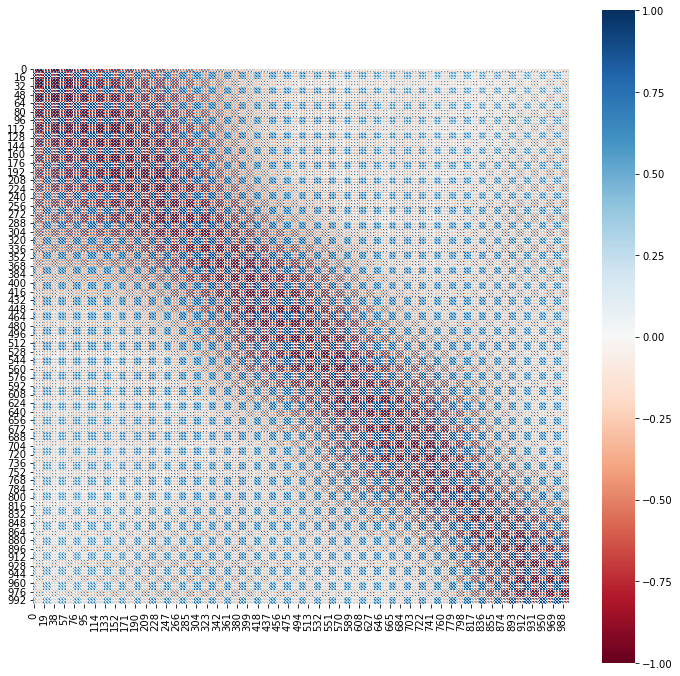

In [535]:
plt.figure(figsize=(12,12))
sns.heatmap(corr_mat[:1000,:1000], cmap="RdBu", square=True, linewidths=0., vmin=-1, vmax=1, center=0, robust=True)

<AxesSubplot:>

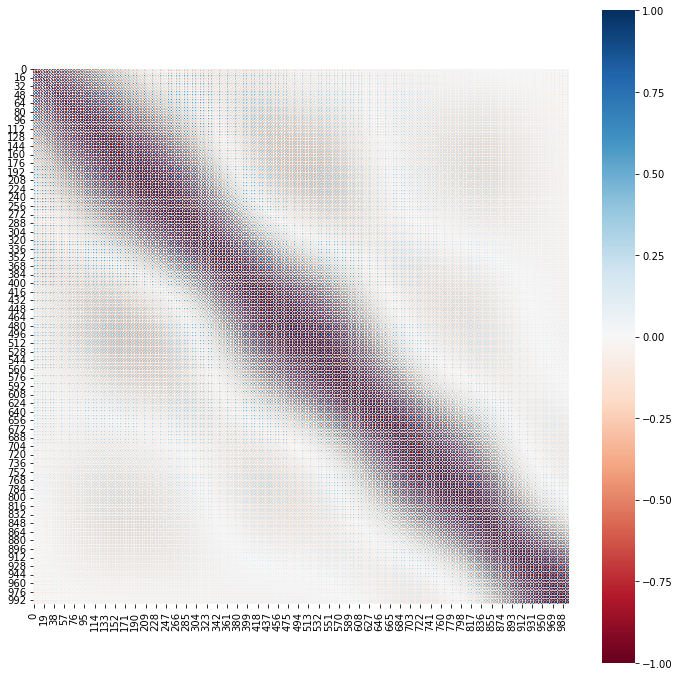

In [655]:
plt.figure(figsize=(12,12))
sns.heatmap(corr_mat[1000:2000,1000:2000], cmap="RdBu", square=True, linewidths=0., vmin=-1, vmax=1, center=0, robust=True)

In [546]:
ax.hlines?

Signature:
ax.hlines(
    y,
    xmin,
    xmax,
    colors=None,
    linestyles='solid',
    label='',
    *,
    data=None,
    **kwargs,
)
Docstring:
Plot horizontal lines at each *y* from *xmin* to *xmax*.

Parameters
----------
y : float or array-like
    y-indexes where to plot the lines.

xmin, xmax : float or array-like
    Respective beginning and end of each line. If scalars are
    provided, all lines will have same length.

colors : list of colors, default: :rc:`lines.color`

linestyles : {'solid', 'dashed', 'dashdot', 'dotted'}, optional

label : str, default: ''

Returns
-------
`~matplotlib.collections.LineCollection`

Other Parameters
----------------
data : indexable object, optional
    If given, the following parameters also accept a string ``s``, which is
    interpreted as ``data[s]`` (unless this raises an exception):

    *y*, *xmin*, *xmax*, *colors*
**kwargs :  `~matplotlib.collections.LineCollection` properties.

See Also
--------
vlines : vertical lines
axhli

In [548]:
A.T

tensor([[ 1.1000, -0.5000,  0.3300,  1.1000,  0.5500, -0.2500],
        [-0.5000,  0.2000,  0.3300, -0.5000, -0.2500,  0.1000]])

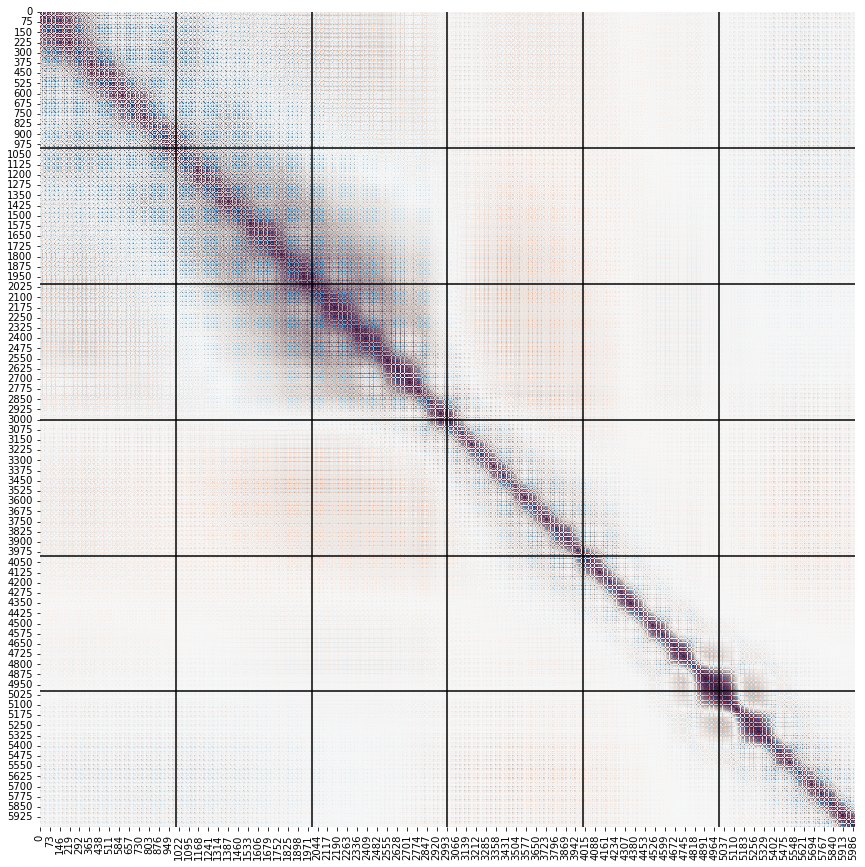

In [547]:
plt.figure(figsize=(15,15))
blocks = np.arange(1000,6000,1000)
ax = sns.heatmap(corr_mat, cmap="RdBu", square=True, linewidths=0., vmin=-1, vmax=1, center=0, robust=True, cbar=False)
ax.hlines(blocks, *ax.get_xlim(), colors="black")
ax.vlines(blocks, *ax.get_ylim(), colors="black")

In [361]:
A.T

tensor([[ 1.1000, -0.5000,  0.3300,  1.1000,  0.5500, -0.2500],
        [-0.5000,  0.2000,  0.3300, -0.5000, -0.2500,  0.1000]])

In [551]:
f_hat = mean.detach().numpy()

<AxesSubplot:>

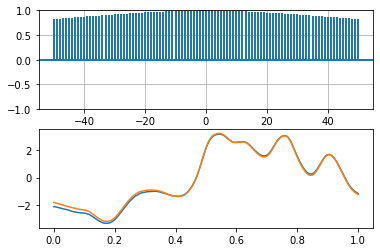

In [776]:
fig, axes = plt.subplots(2, 1, sharex=False)
axes[0].xcorr(f_hat[:,0], f_hat[:,3], usevlines=True, maxlags=50, normed=True, lw=2)
axes[0].grid(True)
axes[0].set_ylim([-1, 1])

sns.lineplot(train_x, f_hat[:,0], ax=axes[1])
sns.lineplot(train_x, f_hat[:,3], ax=axes[1])

In [739]:
1/.5

2.0

In [762]:
def corr_transform(x): 
    symbol = np.where(x<0, -1, 1)
    t_corr = (symbol * np.exp(-(1-np.abs(x))/.2))
    return t_corr

<AxesSubplot:>

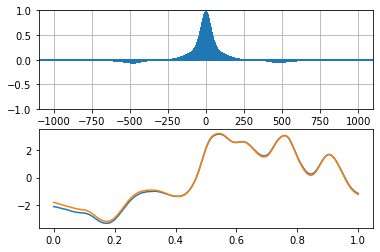

In [775]:
fig, axes = plt.subplots(2, 1, sharex=False)
axes[0].xcorr(f_hat[:,0], f_hat[:,3], usevlines=True, maxlags=999, normed=True, lw=2, transform_fn=corr_transform)
axes[0].grid(True)
axes[0].set_ylim([-1, 1])

sns.lineplot(train_x, f_hat[:,0], ax=axes[1])
sns.lineplot(train_x, f_hat[:,3], ax=axes[1])

<AxesSubplot:>

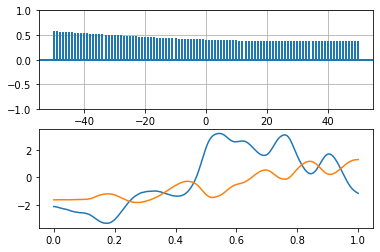

In [773]:
fig, axes = plt.subplots(2, 1, sharex=False)
axes[0].xcorr(f_hat[:,0], f_hat[:,2], usevlines=True, maxlags=50, normed=True, lw=2)
axes[0].grid(True)
axes[0].set_ylim([-1, 1])

sns.lineplot(train_x, f_hat[:,0], ax=axes[1])
sns.lineplot(train_x, f_hat[:,2], ax=axes[1])

In [554]:
A.T

tensor([[ 1.1000, -0.5000,  0.3300,  1.1000,  0.5500, -0.2500],
        [-0.5000,  0.2000,  0.3300, -0.5000, -0.2500,  0.1000]])

<AxesSubplot:>

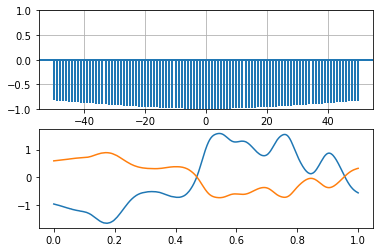

In [770]:
fig, axes = plt.subplots(2, 1, sharex=False)
axes[0].xcorr(f_hat[:,4], f_hat[:,5], usevlines=True, maxlags=50, normed=True, lw=2)
axes[0].grid(True)
axes[0].set_ylim([-1, 1])

sns.lineplot(train_x, f_hat[:,4], ax=axes[1])
sns.lineplot(train_x, f_hat[:,5], ax=axes[1])

<function matplotlib.axes._axes.Axes.xcorr(self, x, y, normed=True, detrend=<function detrend_none at 0x7fe3871e7700>, usevlines=True, maxlags=10, *, data=None, **kwargs)>

In [764]:
def xcorr(self, x, y, normed=True, usevlines=True, maxlags=10, transform_fn=None, **kwargs):
        
    Nx = len(x)
    if Nx != len(y):
        raise ValueError('x and y must be equal length')

    correls = np.correlate(x, y, mode="full")

    if normed:
        correls /= np.sqrt(np.dot(x, x) * np.dot(y, y))

    if maxlags is None:
        maxlags = Nx - 1

    if maxlags >= Nx or maxlags < 1:
        raise ValueError('maxlags must be None or strictly '
                            'positive < %d' % Nx)

    lags = np.arange(-maxlags, maxlags + 1)
    correls = correls[Nx - 1 - maxlags:Nx + maxlags]
    
    if transform_fn is not None:
        correls = transform_fn(correls)

    if usevlines:
        a = self.vlines(lags, [0], correls, **kwargs)
        # Make label empty so only vertical lines get a legend entry
        kwargs.pop('label', '')
        b = self.axhline(**kwargs)

    return lags, correls, a, b

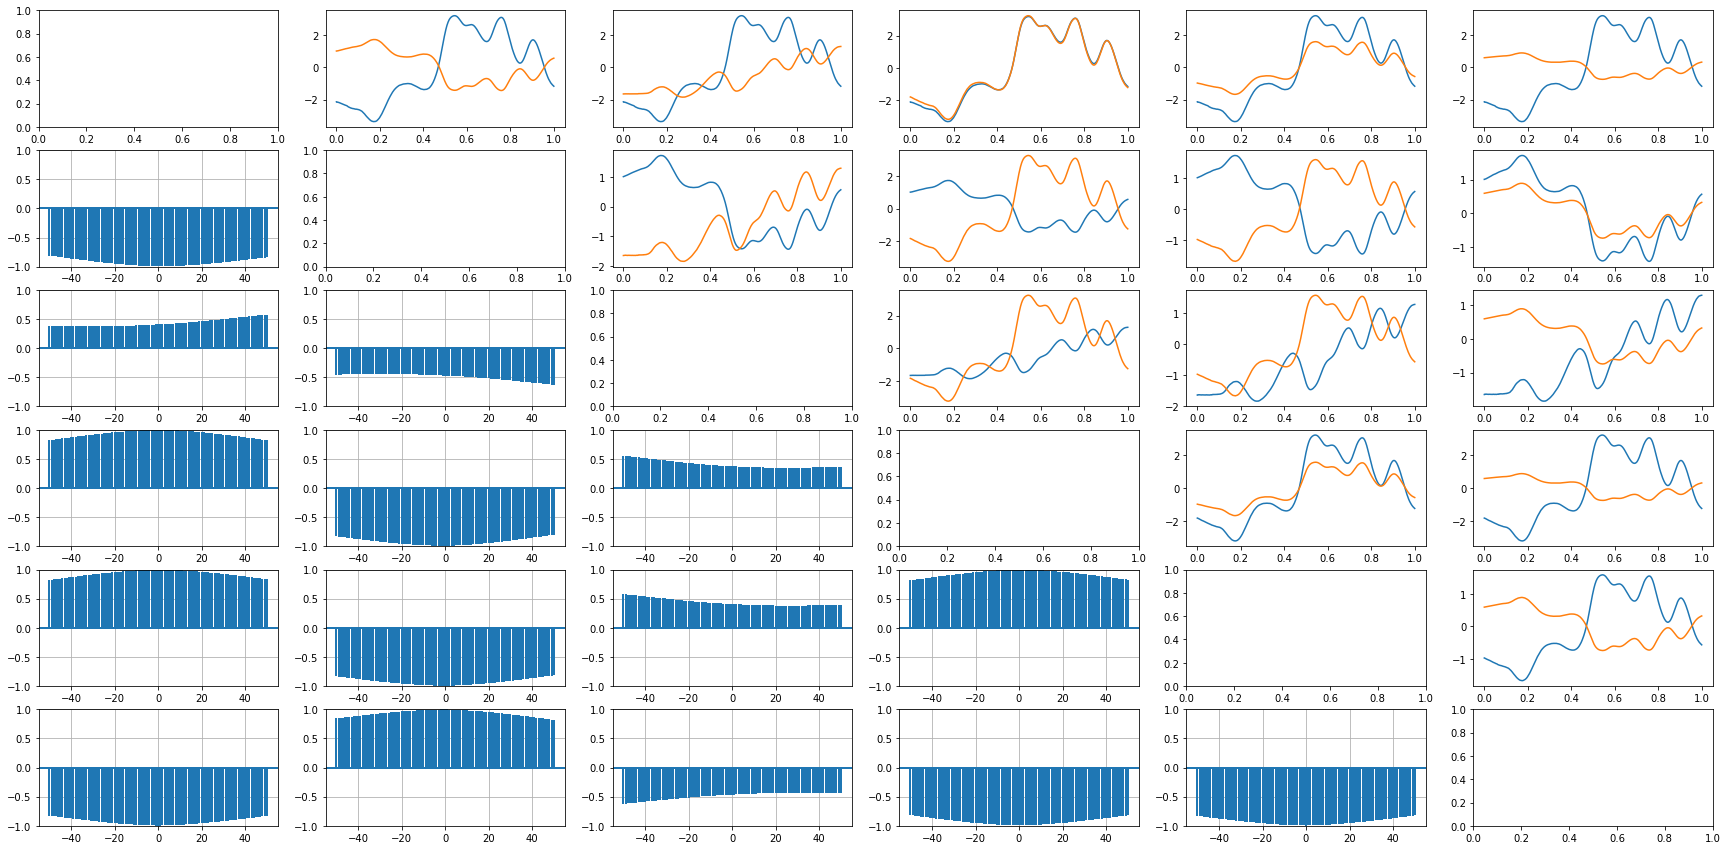

In [779]:
plt.Axes.xcorr = xcorr
fig, axes = plt.subplots(6, 6, sharex=False, sharey=False, figsize=(30,15))
for i in range(6):
    for j in range(6):
        if i > j:
            axes[i,j].xcorr(f_hat[:,i], f_hat[:,j], usevlines=True, maxlags=50, normed=True, lw=2)
            axes[i,j].grid(True)
            axes[i,j].set_ylim([-1, 1])
        elif i < j:
            sns.lineplot(train_x, f_hat[:,i], ax=axes[i,j])
            sns.lineplot(train_x, f_hat[:,j], ax=axes[i,j])
            # axes[i,j].xcorr(f_hat[:,i], f_hat[:,j], maxlags=999, transform_fn=corr_transform)
            # axes[i,j].set_ylim([-1, 1])
            # sns.lineplot(x1, corr_transform(x2))
            # plt.ylim([-1,1])
            # axes[j,i].xcorr(f_hat[:,j], f_hat[:,i], usevlines=True, maxlags=999, normed=True, lw=2)
            # axes[j,i].grid(True)
            # axes[j,i].set_ylim([-1, 1])

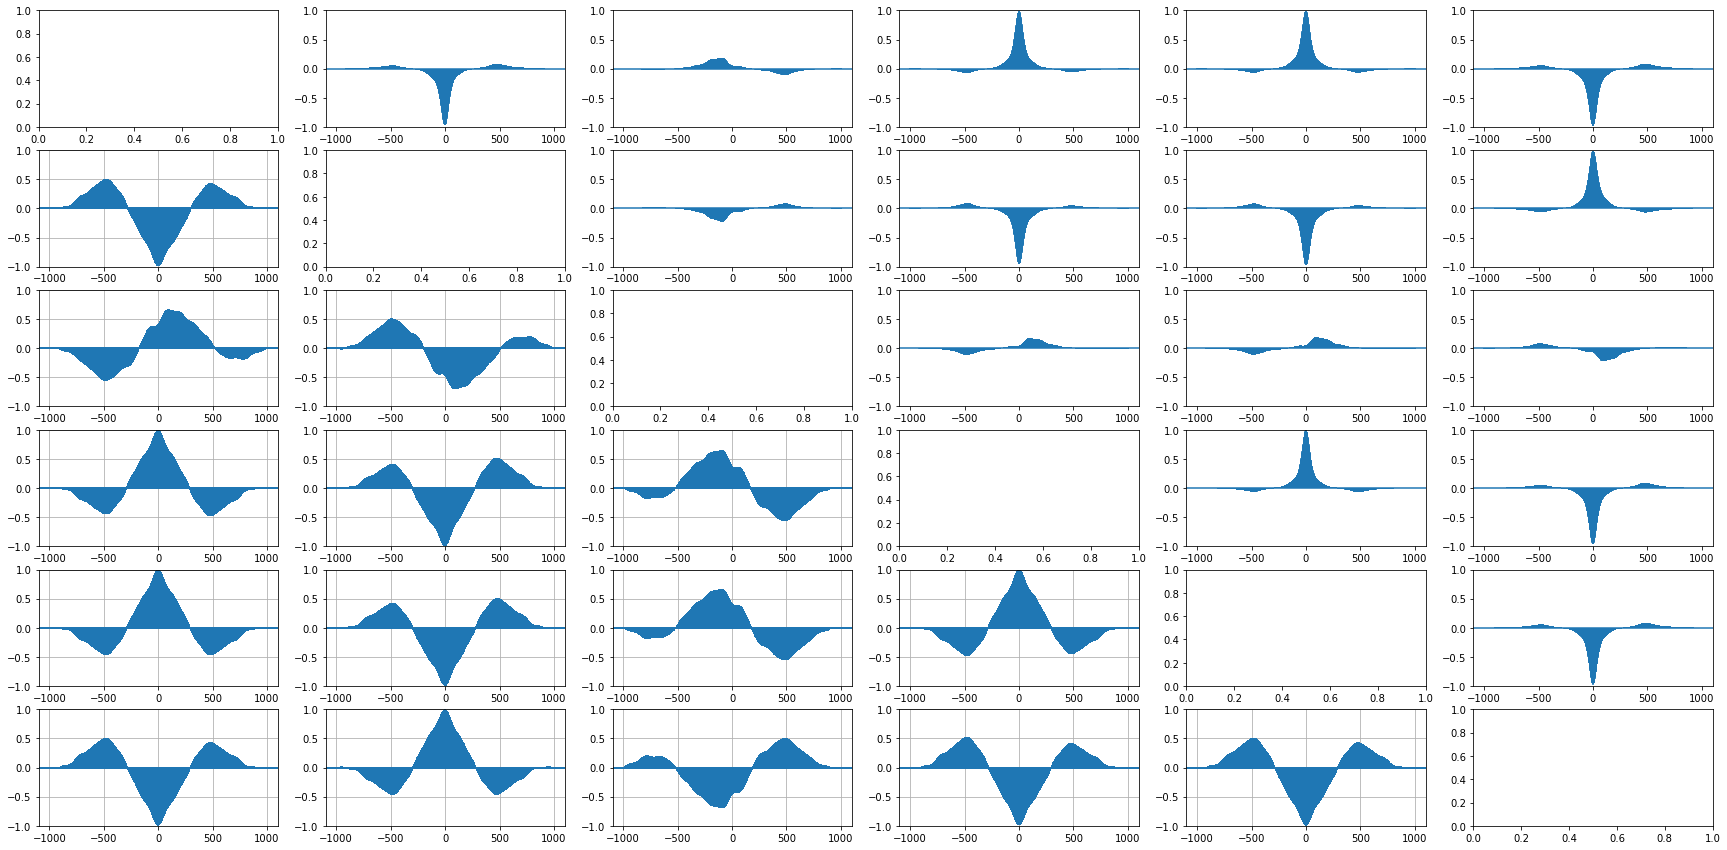

In [765]:
plt.Axes.xcorr = xcorr
fig, axes = plt.subplots(6, 6, sharex=False, sharey=False, figsize=(30,15))
for i in range(6):
    for j in range(6):
        if i > j:
            axes[i,j].xcorr(f_hat[:,i], f_hat[:,j], usevlines=True, maxlags=999, normed=True, lw=2)
            axes[i,j].grid(True)
            axes[i,j].set_ylim([-1, 1])
        elif i < j:
            # sns.lineplot(train_x, f_hat[:,i], ax=axes[i,j])
            # sns.lineplot(train_x, f_hat[:,j], ax=axes[i,j])
            axes[i,j].xcorr(f_hat[:,i], f_hat[:,j], maxlags=999, transform_fn=corr_transform)
            axes[i,j].set_ylim([-1, 1])
            # sns.lineplot(x1, corr_transform(x2))
            # plt.ylim([-1,1])
            # axes[j,i].xcorr(f_hat[:,j], f_hat[:,i], usevlines=True, maxlags=999, normed=True, lw=2)
            # axes[j,i].grid(True)
            # axes[j,i].set_ylim([-1, 1])